In [1]:
import pandas as pd
import numpy as np

# Plot training data

I want to start by taking a look at the training data. I expect that we'll see an increase in bike usage if the weather is nice, especially in the spring and fall when the weather is moderate. I also expect peaks at morning and evening rush hours on workdays, when commuters ride to and from work, as well as peaks closer to the middle of the day on weekends and holidays when cyclists enjoy casual rides.

In [2]:
training = pd.read_csv("train.csv") 
training.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [3]:
training.index.shape

(10886,)

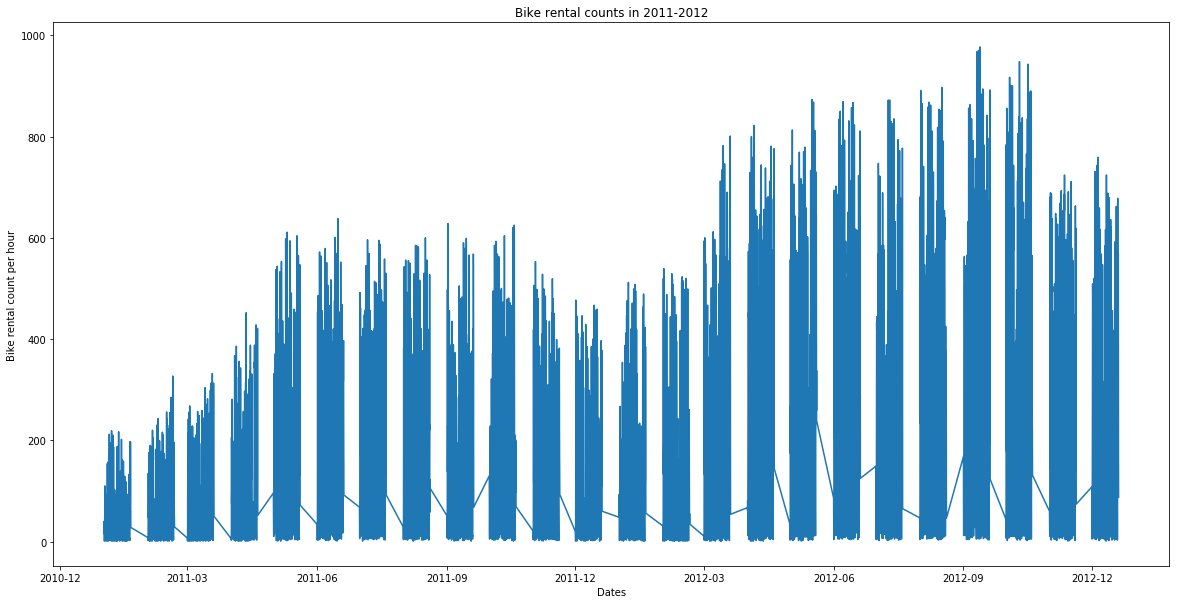

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the training data
plt.figure(figsize=(20,10))
plt.xlabel('Dates')
plt.ylabel('Bike rental count per hour')
plt.title('Bike rental counts in 2011-2012')
plt.plot(pd.to_datetime(training['datetime']), training['count'])

Note the lack of bike rentals in the winter months.
The leap in use from spring-summer-autumn 2011 to the same period in 2012 might be due to the recent implementation of bike share programs. Washington DC introduced its bike share program in 2008.
Evidently Alexandria also launched 120 stations in August 2012.

Keep in mind that dates from the 20th to the end of each month are skipped as they belong in the training data set.

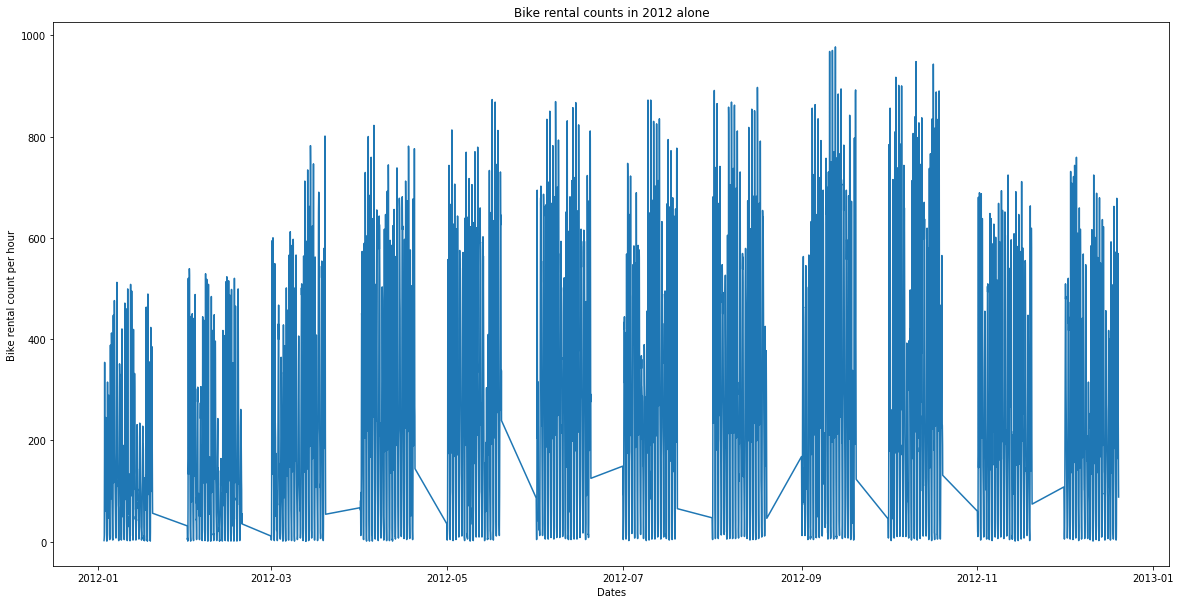

In [5]:
# Yearly
plt.figure(figsize=(20,10))
plt.xlabel('Dates')
plt.ylabel('Bike rental count per hour')
plt.title('Bike rental counts in 2012 alone')
plt.plot(pd.to_datetime(training['datetime'][24*19*12:]), training['count'][24*19*12:])

Interesting periods (weeks in the middle of the summer, a couple of weeks in the winter and fall) that seem to receive less activity.

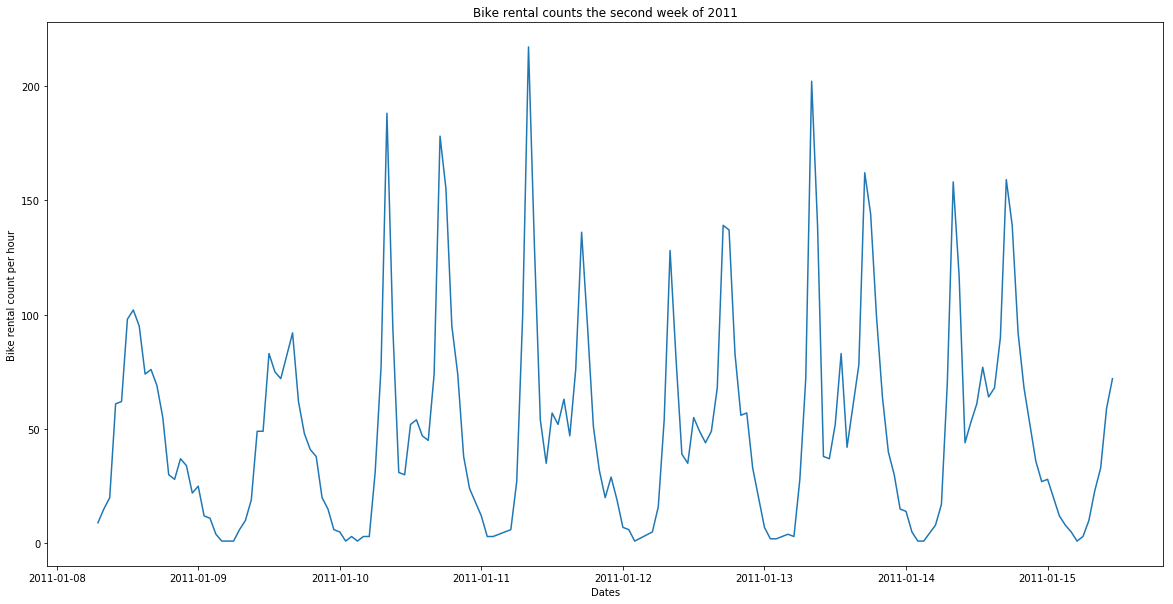

In [6]:
# Weekly
# I picked the week after the first week after New Years to avoid the New Year holidays
plt.figure(figsize=(20,10))
plt.xlabel('Dates')
plt.ylabel('Bike rental count per hour')
plt.title('Bike rental counts the second week of 2011')
plt.plot(pd.to_datetime(training['datetime'][24*7:24*7*2]), training['count'][24*7:24*7*2])

As expected, there are two single humps on two days in a row (presumably on the weekend) and two peaks per day on every other day (presumably weekdays).

# Taking a look at the columns that affect this 

In [8]:
# Normalize the columns to better visualize the correlation between the columns and the bike rental count

peak = training['count'].max()
weather_peak = training['weather'].max()
atemp_peak = training['atemp'].max()

season = pd.Series(training['season']*peak/4) # encoded season (1: spring; 2: summer; 3: fall; 4: winter)
holiday = pd.Series(training['holiday']*peak) 
workday = pd.Series(training['workingday']*peak) # neither weekend or holiday
weather = pd.Series(training['weather']*peak/weather_peak) # encoded weather ( 1: Mostly clear weather; 2: Overcast, poor visibility; 3: Light to medium precipitation, storm; 4: Heavy precipitation, bad weather )
atemp = pd.Series(training['atemp']*peak/atemp_peak) # real-feel temp

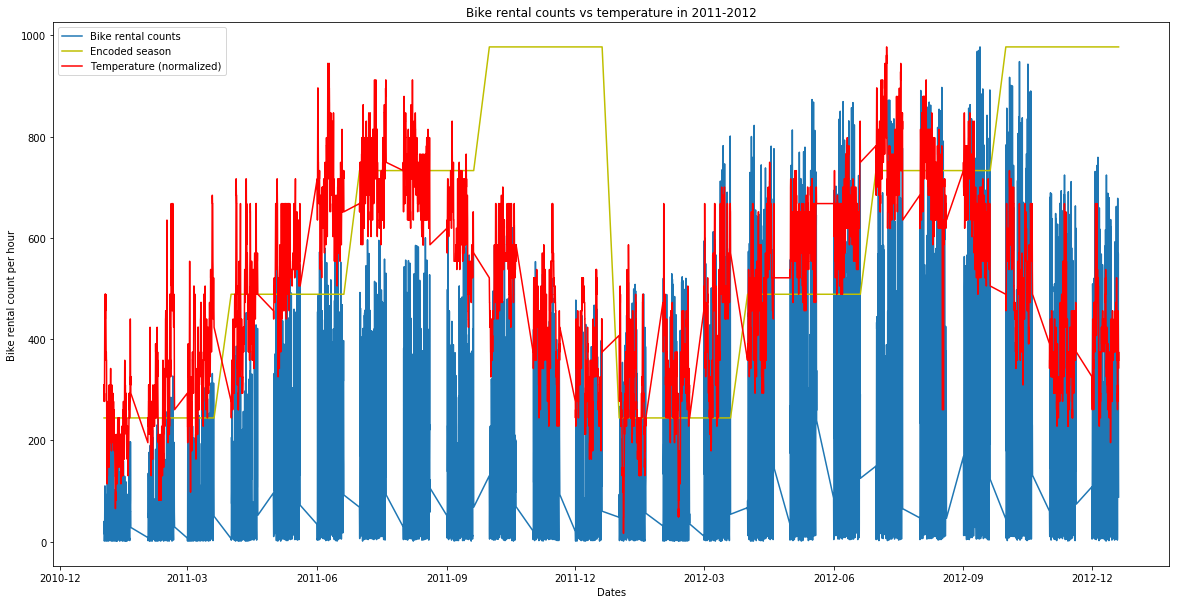

In [9]:
# Temperature and season are likely major factors in the number of bike rentals, so I'll start by plotting those

plt.figure(figsize=(20,10))
plt.xlabel('Dates')
plt.ylabel('Bike rental count per hour')
plt.title('Bike rental counts vs temperature in 2011-2012')
rentals, = plt.plot(pd.to_datetime(training['datetime']), training['count'])
seas, = plt.plot(pd.to_datetime(training['datetime']), season, 'y')
tmp, = plt.plot(pd.to_datetime(training['datetime']), atemp, 'r')
plt.legend([rentals, seas, tmp], ['Bike rental counts', 'Encoded season', 'Temperature (normalized)'])

Over the year, the bike rental counts seem pretty closely associated with the relative temperature. Aside from some die hards who persist in the fall, and what seems like a heat wave in early July, the rental trend seems to follow that of warm temperatures (not to scale since they've been normalized).

However, notice that rentals per hour tend to increase over the two years. It increases one year to the next, even with no obvious temperature fluctuations.

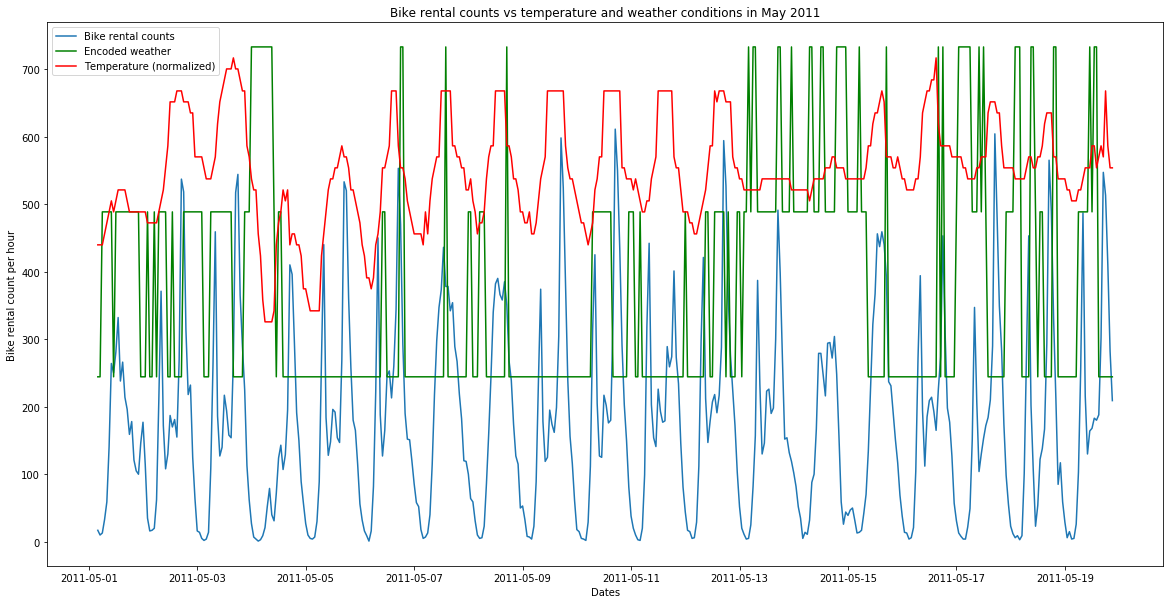

In [11]:
# Lets look at a full month

may_start = 24*19*4-42
may_end = 24*19*4-48+24*19

plt.figure(figsize=(20,10))
plt.xlabel('Dates')
plt.ylabel('Bike rental count per hour')
plt.title('Bike rental counts vs temperature and weather conditions in May 2011')
rentals, = plt.plot(pd.to_datetime(training['datetime'][may_start:may_end]), training['count'][may_start:may_end])
weath, = plt.plot(pd.to_datetime(training['datetime'][may_start:may_end]), weather[may_start:may_end], 'g')
tmp, = plt.plot(pd.to_datetime(training['datetime'][may_start:may_end]), atemp[may_start:may_end], 'r')
plt.legend([rentals, weath, tmp], ['Bike rental counts', 'Encoded weather', 'Temperature (normalized)'])

Since the higher the encoded value for the weather, the worse the weather is, it seems pretty logical to see dips in rideship when the weather encoded value rises.

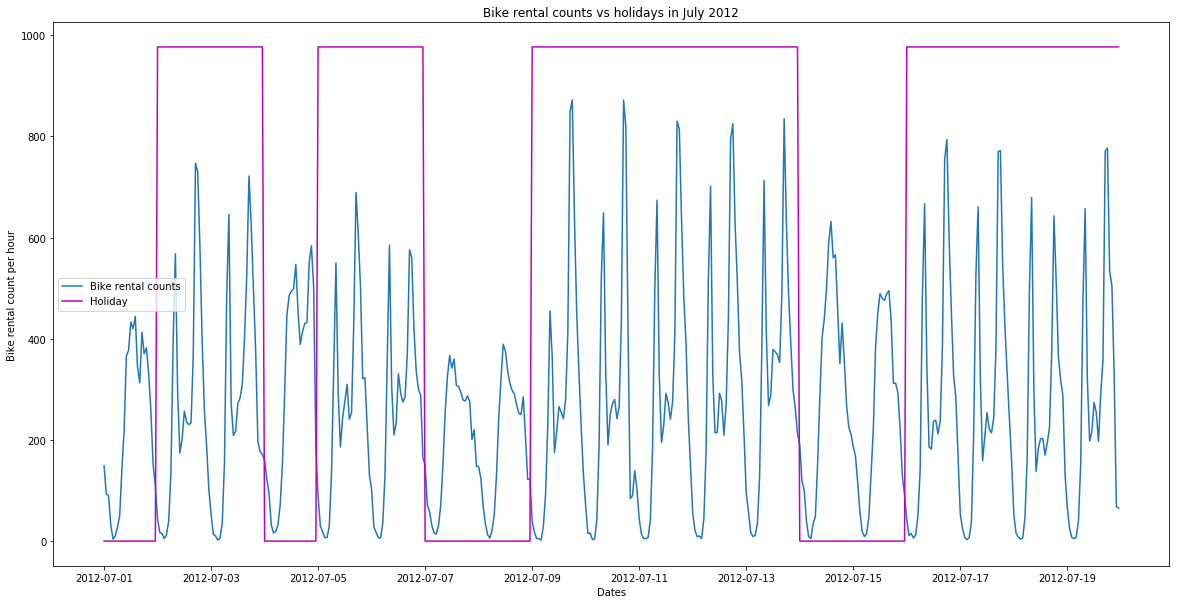

In [12]:
# Lets look at July for holidays, heat, etc...

july_start = 24*19*12+24*19*6-57
july_end = july_start+24*19

plt.figure(figsize=(20,10))
plt.xlabel('Dates')
plt.ylabel('Bike rental count per hour')
plt.title('Bike rental counts vs holidays in July 2012')
rentals, = plt.plot(pd.to_datetime(training['datetime'][july_start:july_end]), training['count'][july_start:july_end])
hday, = plt.plot(pd.to_datetime(training['datetime'][july_start:july_end]), workday[july_start:july_end], 'm')
plt.legend([rentals, hday], ['Bike rental counts', 'Holiday'])

You can see the bump on the 4th of July is very particular. It almost has the two workday peaks, but they aren't as sharp and there are more rentals during the middle of the day than there would be on a typical workday.

# Prep Data Set

I want to add some features: such as hour of the day in order to capture the hourly trends over a day, as well as some bins over time in order to capture the steady increase in ridership.

I want to exclude the first hour of each month because we ~ don't technically have weather data for those hours ~
I also want to save the last day of each month as a control group.

In [13]:
# Going to load up the testing data now in order to perform preparations in parallel
testing = pd.read_csv("test.csv")
testing.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2  2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3  2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4  2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

In [14]:
import datetime

# Add in a couple of features, such as formatted (non-String) datetime as dates, hour, and year
training['dates'] = pd.to_datetime(training['datetime'])
training['hour'] = training['dates'].dt.hour
training['year'] = training['dates'].dt.year
training.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count               dates  hour  \
0        81        0.0       3          13     16 2011-01-01 00:00:00     0   
1        80        0.0       8          32     40 2011-01-01 01:00:00     1   
2        80        0.0       5          27     32 2011-01-01 02:00:00     2   
3        75        0.0       3          10     13 2011-01-01 03:00:00     3   
4        75        0.0       0           1      1 2011-01-01 04:00:00     4   

   year  
0  2011  
1  2011  
2  2011  
3  2011  
4  2011

In [15]:
# Do the same with the testing data
testing['dates'] = pd.to_datetime(testing['datetime'])
testing['hour'] = testing['dates'].dt.hour
testing['year'] = testing['dates'].dt.year
testing.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2  2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3  2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4  2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed               dates  hour  year  
0        56    26.0027 2011-01-20 00:00:00     0  2011  
1        56     0.0000 2011-01-20 01:00:00     1  2011  
2        56     0.0000 2011-01-20 02:00:00     2  2011  
3        56    11.0014 2011-01-20 03:00:00     3  2011  
4        56    11.0014 2011-01-20 04:00:00     4  2011

In [16]:
# Put some of the training data aside to be used in the testing data
last_hour = training[(training['dates'].dt.day == 19) & (training['dates'].dt.hour == 23)]

In [17]:
# Shift the weather and time-sensitive data back by an hour
train_full_shifted = training.copy()
train_full_shifted.loc[:, 'weather':'windspeed'] = train_full_shifted.loc[:, 'weather':'windspeed'].shift(periods=1, axis='index')
train_full_shifted.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0      NaN   NaN     NaN   
1  2011-01-01 01:00:00       1        0           0      1.0  9.84  14.395   
2  2011-01-01 02:00:00       1        0           0      1.0  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0      1.0  9.02  13.635   
4  2011-01-01 04:00:00       1        0           0      1.0  9.84  14.395   

   humidity  windspeed  casual  registered  count               dates  hour  \
0       NaN        NaN       3          13     16 2011-01-01 00:00:00     0   
1      81.0        0.0       8          32     40 2011-01-01 01:00:00     1   
2      80.0        0.0       5          27     32 2011-01-01 02:00:00     2   
3      80.0        0.0       3          10     13 2011-01-01 03:00:00     3   
4      75.0        0.0       0           1      1 2011-01-01 04:00:00     4   

   year  
0  2011  
1  2011  
2  2011  
3  2011  
4  2011

In [18]:
# Do the same with the testing data
test_shifted = testing.copy()
test_shifted.loc[:, 'weather':'windspeed'] = test_shifted.loc[:, 'weather':'windspeed'].shift(periods=1, axis='index')
test_shifted.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1      NaN    NaN     NaN   
1  2011-01-20 01:00:00       1        0           1      1.0  10.66  11.365   
2  2011-01-20 02:00:00       1        0           1      1.0  10.66  13.635   
3  2011-01-20 03:00:00       1        0           1      1.0  10.66  13.635   
4  2011-01-20 04:00:00       1        0           1      1.0  10.66  12.880   

   humidity  windspeed               dates  hour  year  
0       NaN        NaN 2011-01-20 00:00:00     0  2011  
1      56.0    26.0027 2011-01-20 01:00:00     1  2011  
2      56.0     0.0000 2011-01-20 02:00:00     2  2011  
3      56.0     0.0000 2011-01-20 03:00:00     3  2011  
4      56.0    11.0014 2011-01-20 04:00:00     4  2011

In [19]:
# Exclude 1 day per month to serve as control, as well as the first hour of every month 
train = train_full_shifted[(train_full_shifted['dates'].dt.day < 19) 
                 & (train_full_shifted['dates'].dt.day > 1) 
                 | ((train_full_shifted['dates'].dt.day == 1) & (train_full_shifted['dates'].dt.hour > 0))]
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
1  2011-01-01 01:00:00       1        0           0      1.0  9.84  14.395   
2  2011-01-01 02:00:00       1        0           0      1.0  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0      1.0  9.02  13.635   
4  2011-01-01 04:00:00       1        0           0      1.0  9.84  14.395   
5  2011-01-01 05:00:00       1        0           0      1.0  9.84  14.395   

   humidity  windspeed  casual  registered  count               dates  hour  \
1      81.0        0.0       8          32     40 2011-01-01 01:00:00     1   
2      80.0        0.0       5          27     32 2011-01-01 02:00:00     2   
3      80.0        0.0       3          10     13 2011-01-01 03:00:00     3   
4      75.0        0.0       0           1      1 2011-01-01 04:00:00     4   
5      75.0        0.0       0           1      1 2011-01-01 05:00:00     5   

   year  
1  2011  
2  2011  
3  2011  
4  2011  
5  2011

In [20]:
# Because of the shifting and the jump between the end of each month and the next date in the testing set (the 20th)
# I need to replace the first hour of the 20th with the weather:windspeed data from the training data
first_hour = test_shifted[(test_shifted['dates'].dt.day == 20) & (test_shifted['dates'].dt.hour == 0)]
first_hour.head()

datetime  season  holiday  workingday  weather   temp  \
0     2011-01-20 00:00:00       1        0           1      NaN    NaN   
257   2011-02-20 00:00:00       1        0           0      2.0   6.56   
460   2011-03-20 00:00:00       1        0           0      2.0  13.12   
744   2011-04-20 00:00:00       2        0           1      3.0  10.66   
1008  2011-05-20 00:00:00       2        0           1      1.0  18.04   

       atemp  humidity  windspeed      dates  hour  year  
0        NaN       NaN        NaN 2011-01-20     0  2011  
257    9.850      64.0     6.0032 2011-02-20     0  2011  
460   14.395      81.0    26.0027 2011-03-20     0  2011  
744   12.880     100.0    11.0014 2011-04-20     0  2011  
1008  21.970      67.0     7.0015 2011-05-20     0  2011

In [21]:
# Note that the indices don't match up between the last hour given for each month (19th) in the training data
# and the first hour given for each month (20th) in the testing data.
# By reindexing the last hour data, it becomes easier to replace testing values
new_last_hour_index = last_hour.set_index(first_hour.index.values)
new_last_hour_index.head()

datetime  season  holiday  workingday  weather   temp  \
0     2011-01-19 23:00:00       1        0           1        1  12.30   
257   2011-02-19 23:00:00       1        0           0        1  11.48   
460   2011-03-19 23:00:00       1        0           0        1  15.58   
744   2011-04-19 23:00:00       2        0           1        1  18.86   
1008  2011-05-19 23:00:00       2        0           1        1  19.68   

       atemp  humidity  windspeed  casual  registered  count  \
0     13.635        52    31.0009       1          27     28   
257   12.120        33    30.0026       4          25     29   
460   19.695        40    19.9995      13          37     50   
744   22.725        88     6.0032      11          41     52   
1008  23.485        94     0.0000       9          63     72   

                   dates  hour  year  
0    2011-01-19 23:00:00    23  2011  
257  2011-02-19 23:00:00    23  2011  
460  2011-03-19 23:00:00    23  2011  
744  2011-04-19 23:00:00    23  2011  
1008 2011-05-19 23:00:00    23  2011

In [22]:
# We integrate these values into the original testing data
for i in first_hour.index.values:
    test_shifted.loc[i, 'weather':'windspeed'] = new_last_hour_index.loc[i, 'weather':'windspeed']
    
test_shifted.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1      1.0  12.30  13.635   
1  2011-01-20 01:00:00       1        0           1      1.0  10.66  11.365   
2  2011-01-20 02:00:00       1        0           1      1.0  10.66  13.635   
3  2011-01-20 03:00:00       1        0           1      1.0  10.66  13.635   
4  2011-01-20 04:00:00       1        0           1      1.0  10.66  12.880   

   humidity  windspeed               dates  hour  year  
0      52.0    31.0009 2011-01-20 00:00:00     0  2011  
1      56.0    26.0027 2011-01-20 01:00:00     1  2011  
2      56.0     0.0000 2011-01-20 02:00:00     2  2011  
3      56.0     0.0000 2011-01-20 03:00:00     3  2011  
4      56.0    11.0014 2011-01-20 04:00:00     4  2011

In [23]:
# Finalize the test data by concatenating the columns to use as input
test = pd.concat([test_shifted.loc[:,'season':'windspeed'], test_shifted.loc[:, 'hour':'year']], axis=1)
test.head()

season  holiday  workingday  weather   temp   atemp  humidity  windspeed  \
0       1        0           1      1.0  12.30  13.635      52.0    31.0009   
1       1        0           1      1.0  10.66  11.365      56.0    26.0027   
2       1        0           1      1.0  10.66  13.635      56.0     0.0000   
3       1        0           1      1.0  10.66  13.635      56.0     0.0000   
4       1        0           1      1.0  10.66  12.880      56.0    11.0014   

   hour  year  
0     0  2011  
1     1  2011  
2     2  2011  
3     3  2011  
4     4  2011

In [24]:
# Create the control sample from the training data to test the models
control = train_full_shifted[(train_full_shifted['dates'].dt.day == 19)]
control.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
408  2011-01-19 00:00:00       1        0           1      2.0  9.02  13.635   
409  2011-01-19 01:00:00       1        0           1      2.0  9.02  13.635   
410  2011-01-19 02:00:00       1        0           1      3.0  9.02  11.365   
411  2011-01-19 04:00:00       1        0           1      3.0  9.02  11.365   
412  2011-01-19 05:00:00       1        0           1      3.0  9.02  11.365   

     humidity  windspeed  casual  registered  count               dates  hour  \
408      93.0     0.0000       0           3      3 2011-01-19 00:00:00     0   
409      93.0     0.0000       1           6      7 2011-01-19 01:00:00     1   
410      93.0     8.9981       0           3      3 2011-01-19 02:00:00     2   
411      93.0     8.9981       1           1      2 2011-01-19 04:00:00     4   
412      93.0     8.9981       0           7      7 2011-01-19 05:00:00     5   

     year  
408  2011  
409  2011  
410  2011  
411  2011  
412  2011

In [25]:
# Concatenate set of columns from the training dataframe to create the X for our fit
train_X = pd.concat([train.loc[:,'season':'windspeed'], train.loc[:, 'hour':'year']], axis=1)
train_X.head()

season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
1       1        0           0      1.0  9.84  14.395      81.0        0.0   
2       1        0           0      1.0  9.02  13.635      80.0        0.0   
3       1        0           0      1.0  9.02  13.635      80.0        0.0   
4       1        0           0      1.0  9.84  14.395      75.0        0.0   
5       1        0           0      1.0  9.84  14.395      75.0        0.0   

   hour  year  
1     1  2011  
2     2  2011  
3     3  2011  
4     4  2011  
5     5  2011

In [26]:
# Concatenate set of columns for the control
control_X = pd.concat([control.loc[:,'season':'windspeed'], control.loc[:, 'hour':'year']], axis=1)
control_X.head()

season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
408       1        0           1      2.0  9.02  13.635      93.0     0.0000   
409       1        0           1      2.0  9.02  13.635      93.0     0.0000   
410       1        0           1      3.0  9.02  11.365      93.0     8.9981   
411       1        0           1      3.0  9.02  11.365      93.0     8.9981   
412       1        0           1      3.0  9.02  11.365      93.0     8.9981   

     hour  year  
408     0  2011  
409     1  2011  
410     2  2011  
411     4  2011  
412     5  2011

### Linear Regresssion

In [27]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
print(lr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [28]:
lr.fit(train_X, train.loc[:,'count'])
predicted_count = lr.predict(control_X)
score = lr.score(control_X, control.loc[:,'count'])
print(score)

0.337669619353


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


An R^2 coefficient of 0.27 is definitely Not Idealâ„¢ so lets move on

### Ridge Regression
Ridge regression has built in support for possibly correlated inputs

In [29]:
ridge = linear_model.Ridge()
print(ridge)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [30]:
ridge.fit(train_X, train.loc[:,'count'])
predicted_count = ridge.predict(control_X)
score = ridge.score(control_X, control.loc[:,'count'])
print(score)

0.337667947649


This is still not great, so lets move on

### Random Forest Regressor
Because Random Forests are great!

In [31]:
from sklearn import ensemble

rf = ensemble.RandomForestRegressor()
print(rf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [32]:
rf_default.fit(train_X, train.loc[:,'count'])
predicted_count = rf_default.predict(control_X)
score = rf_default.score(control_X, control.loc[:,'count'])
print(score)

0.906117872775


### Try some different parameters and try to optimize the score
The following includes some R^2 scores for some relevant parameters of the random forest model

In [79]:
# default 0.906 : n_estimators=10, max_depth=None, min_samples_split=2

# 0.911 : n_estimators=25
# 0.913 : n_estimators=50
# 0.906 : n_estimators=75

# 0.915 : n_estimators=25, max_depth=200
# 0.912 : n_estimators=50, 
# 0.915 : n_estimators=75,
# 0.911 : n_estimators=90

# 0.913 : n_estimators=25, max_depth=100
# 0.911 : n_estimators=50, 
# 0.913 : n_estimators=75

# 0.908 : n_estimators=25, max_depth=50
# 0.914 : n_estimators=50, 
# 0.914 : n_estimators=75

# 0.915 : n_estimators=50, max_depth=100, min_samples_split=4
# 0.912 : n_estimators=50, max_depth=100, min_samples_split=6
# 0.916 : n_estimators=50, max_depth=100, min_samples_split=10
# 0.914 : n_estimators=50, max_depth=100, min_samples_split=12
# 0.911 : n_estimators=50, max_depth=100, min_samples_split=16

# 0.914 : n_estimators=75, max_depth=100, min_samples_split=6
# 0.917 : n_estimators=75, max_depth=100, min_samples_split=10
# 0.914 : n_estimators=75, max_depth=100, min_samples_split=16

# 0.914 : n_estimators=100, max_depth=100, min_samples_split=10

rf = ensemble.RandomForestRegressor(n_estimators=75, max_depth=100, min_samples_split=10)
total = 0
for i in range(3):
    rf.fit(train_X, train.loc[:,'count'])
    score = rf.score(control_X, control.loc[:,'count'])
    total += score
print(total/3)

0.914664237635


# Predict number of bike rentals for each test value

In [80]:
y = rf.predict(test)
y

array([  26.03429856,    3.00896049,    2.85618166, ...,  107.94227031,
         69.90273317,   52.94308499])

In [94]:
datetime = pd.Series(testing.loc[:,'datetime'], name='datetime')
predicted = pd.Series(y, name='count')

result = pd.concat([datetime, predicted], axis=1)
result.head()

datetime      count
0  2011-01-20 00:00:00  26.034299
1  2011-01-20 01:00:00   3.008960
2  2011-01-20 02:00:00   2.856182
3  2011-01-20 03:00:00   2.717977
4  2011-01-20 04:00:00   2.387943

In [95]:
result.to_csv('predicted.csv')